# Machine learning in feature Hilbert space

In [58]:
# the version of Yao is 0.4.1 in this notebook
using Yao, Yao.ConstGate
using Plots
using QuAlgorithmZoo: random_diff_circuit, pair_ring
using Random

## Dataset

In [59]:
y(x, y) = Int((2x^2 + y^2) < π)

y (generic function with 1 method)

In [60]:
function generate_train_batch(nbatch::Int)
    xs = rand(nbatch,2)*2π
    xs, y.(xs[:,1], xs[:,2])
end

generate_train_batch (generic function with 1 method)

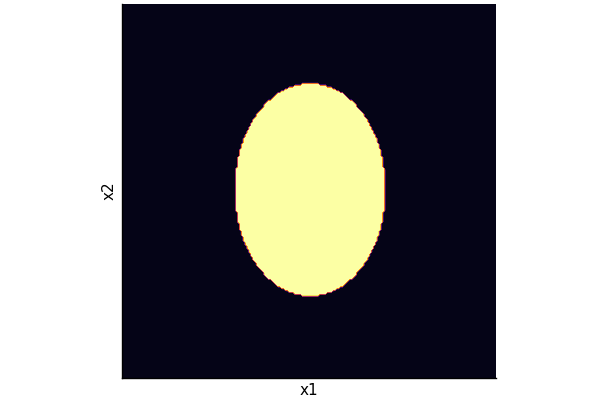

In [61]:
a = -π:0.01π:π
b = -π:0.01π:π
plot(a, b, y, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")

## Model

In [62]:
nbit = 3
circuit = random_diff_circuit(nbit, 2, pair_ring(nbit));

In [63]:
# pick two parameters
rots = collect_blocks(RotationGate, circuit);
tworots = rots[[8,11]]

2-element Array{RotationGate,1}:
 rot(X gate, 0.0)
 rot(X gate, 0.0)

In [64]:
"""
Construct a swap test circuit.
"""
function swap_test(nbits::Int, nstate::Int)
    N = nstate*nbits + 1
    chain(N, put(N, 1=>H),
    chain(N, [chain(N, [control(N, 1, (i+(k*nbits-nbits)+1, i+k*nbits+1)=>SWAP)
    for i=1:nbits]) for k=1:nstate-1]),
    put(N, 1=>H)
)
end

swap_test

In [65]:
"""
calculate the (squared) overlap of two states |<ψ|ψ'>|^2
"""
function state_overlap(reg1::AbstractRegister, reg2::AbstractRegister)
    nbits = nactive(reg1)
    @assert nactive(reg2) == nbits error("Register size mismatch!")
    circuit = swap_test(nbits, 2)
    reg_ancilla = join(reg1, reg2, zero_state(1))
    reg_ancilla |> circuit
    expect(put(2nbits+1, 1=>Z), reg_ancilla) |> real
end

state_overlap

In [66]:
"""
A point in RKHS ψ0 defines a function, f(x) = K(x0,x) = <ψ0, Φ(x)>
"""
function Kf(circuit::AbstractBlock, rots, x, ψ0::AbstractRegister)
    nbit = nqubits(circuit)
    dispatch!.(rots, x)
    ψ = zero_state(nbit) |> circuit
    state_overlap(ψ, ψ0)
end

Kf

## Loss Function

In [67]:
function batched_loss(circuit, rots, xs0, train_batch)
    xs, ys = train_batch
    dispatch!.(rots, xs0)
    loss = 0
    ψ0 = zero_state(nqubits(circuit)) |> circuit
    for (x1, x2, yt) in zip(view(xs, :, 1), view(xs, :, 2), ys)
        loss += abs(Kf(circuit, rots, (x1, x2), ψ0) - yt)
    end
    loss/length(xs)
end

batched_loss (generic function with 1 method)

In [68]:
function miss_rate(circuit, rots, xs0, train_batch)
    xs, ys = train_batch
    dispatch!.(rots, xs0)
    loss = 0
    ψ0 = zero_state(nqubits(circuit)) |> circuit
    for (x1, x2, yt) in zip(view(xs, :, 1), view(xs, :, 2), ys)
        loss += abs(round(Kf(circuit, rots, (x1, x2), ψ0)) - yt)
    end
    loss/length(xs)
end

miss_rate (generic function with 1 method)

## Training

Check the gradients

In [69]:
Random.seed!(6)
dispatch!(circuit, :random)
x0 = randn(2)
tset = generate_train_batch(100)
x1 = copy(x0); x1[2]+=1e-5
loss0 = batched_loss(circuit, tworots, x0, tset)
loss1 = batched_loss(circuit, tworots, x1, tset)
(loss1-loss0)/1e-5

-0.01793243773473563

In [70]:
function circuit_gradient(circuit, tworots, x0, tset)
    grad = zeros(2)
    for i=1:length(x0)
        x0[i]-=π/2
        loss0 = batched_loss(circuit, tworots, x0, tset)
        x0[i]+=π
        loss1 = batched_loss(circuit, tworots, x0, tset)
        grad[i] = (loss1-loss0)/2
        x0[i]-=π/2
    end
    grad
end

circuit_gradient (generic function with 1 method)

In [71]:
circuit_gradient(circuit, tworots, x0, tset)

2-element Array{Float64,1}:
  0.01684518610888462 
 -0.017932444304590053

In [72]:
using Flux: ADAM, Optimise
function train!(circuit, tworots; maxiter::Int=100, lr::Float64=0.1, nbatch::Int=100)
    optimizer = ADAM(lr)
    x0 = rand(2)*2π
    loss_history = Float64[]
    for i=1:maxiter
        tset = generate_train_batch(nbatch)
        grad = circuit_gradient(circuit, tworots, x0, tset)
        Optimise.update!(optimizer, x0, grad)
        push!(loss_history, batched_loss(circuit, tworots, x0, tset))
        @show loss_history[end]
    end
    x0, loss_history
end

train! (generic function with 1 method)

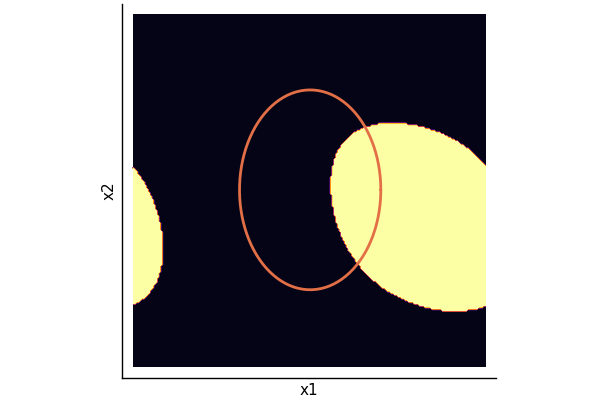

In [73]:
pyplot(leg=false, ticks=nothing)
dispatch!.(tworots, x0)
ψ0 = zero_state(nqubits(circuit)) |> circuit
#l = @layout [a{0.5w} b]
p = plot(a, b, (x,y)->Kf(circuit, tworots, (x, y), ψ0)>0.5, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
#plot!(p[2], a, b, y, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
t = LinRange(0,2π,200)
xs = sqrt(π)*cos.(t)/sqrt(2)
ys = sqrt(π)*sin.(t)
plot!(p[1], xs, ys, lw=2)

In [74]:
xopt, history = train!(circuit, tworots; lr=0.1, nbatch=500)

loss_history[end] = 0.14725654471789212
loss_history[end] = 0.12531638480801313
loss_history[end] = 0.14099230244576552
loss_history[end] = 0.12471743391870452
loss_history[end] = 0.12982493559156014
loss_history[end] = 0.13150033406639106
loss_history[end] = 0.11904014535960168
loss_history[end] = 0.12678008875656097
loss_history[end] = 0.12452870152542189
loss_history[end] = 0.11241546354281627
loss_history[end] = 0.12024256520962896
loss_history[end] = 0.12625043814148984
loss_history[end] = 0.13105607671563207
loss_history[end] = 0.12819707759904597
loss_history[end] = 0.12293738835660156
loss_history[end] = 0.11181753485421497
loss_history[end] = 0.11396932074425785
loss_history[end] = 0.12291308335857368
loss_history[end] = 0.12391186649664607
loss_history[end] = 0.11717895233246342
loss_history[end] = 0.12640487116225757
loss_history[end] = 0.11984455062902638
loss_history[end] = 0.11327948891393949
loss_history[end] = 0.12196873888389383
loss_history[end] = 0.1154011655549888
l

([6.66013, 0.757812], [0.147257, 0.125316, 0.140992, 0.124717, 0.129825, 0.1315, 0.11904, 0.12678, 0.124529, 0.112415  …  0.1138, 0.116719, 0.122583, 0.122999, 0.111468, 0.116018, 0.111959, 0.129624, 0.128649, 0.123692])

In [75]:
dispatch!.(tworots, xopt)
ψ0 = zero_state(nqubits(circuit)) |> circuit

ArrayReg{1, Complex{Float64}, Array...}
    active qubits: 3/3

In [76]:
miss_rate(circuit, tworots, x0, generate_train_batch(1000))

0.105

In [77]:
miss_rate(circuit, tworots, xopt, generate_train_batch(1000))

0.0775

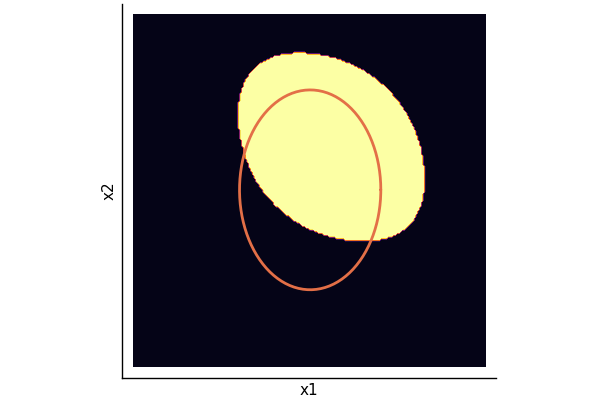

In [79]:
pyplot(leg=false, ticks=nothing)
dispatch!.(tworots, xopt)
ψ0 = zero_state(nqubits(circuit)) |> circuit
p = plot(a, b, (x,y)->Kf(circuit, tworots, (x, y), ψ0)>0.5, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
#plot!(p[2], a, b, y, st = :contourf, aspect_ratio=:equal, xlabel="x1", ylabel="x2")
t = LinRange(0,2π,200)
xs = sqrt(π)*cos.(t)/sqrt(2)
ys = sqrt(π)*sin.(t)
plot!(p[1], xs, ys, lw=2)